# Growth Rate Analysis with Bootstrap 

## import package

In [44]:
import sys;
import numpy as np;
import netCDF4 as nc;
import ChienKim as ck;

from itertools import product
from joblib import Parallel, delayed
from matplotlib import pyplot as plt
from matplotlib.colors import TwoSlopeNorm

sys.path.append("/home/b11209013/Package/");
import Theory as th; #type: ignore
import DataProcess as dp; #type: ignore

## Load data

In [31]:
# dimension dictionary
dims: dict[str, np.ndarray] = dict();

# data dictionary
data: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
);

# variable name list
var_list: list[str] = ["t", "lw", "sw"]

with nc.Dataset("/work/b11209013/2024_Research/MPAS/PC/CNTL_PC.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:];

    for key in var_list:
        data["cntl"][key] = np.nansum(f.variables[key][:2, :, :, :360], axis=0);

with nc.Dataset("/work/b11209013/2024_Research/MPAS/PC/NCRF_PC.nc", "r") as f:
    for key in var_list:
        data["ncrf"][key] = np.nansum(f.variables[key][:2, :, :, :360], axis=0);

## Processing data

### Symmetrizing data

In [32]:
fmt = dp.Format(dims["lat"])

data_sym: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
);

for key in var_list:
    data_sym["cntl"][key] = fmt.sym(data["cntl"][key]).T;
    data_sym["ncrf"][key] = fmt.sym(data["ncrf"][key]).T;


### Random Shuffle data 

In [33]:
# dictionary for shuffle data
data_shuffle: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
);

# random object
for key in var_list:
    data_shuffle["cntl"][key] = np.array([
        np.random.permutation(data_sym["cntl"][key])
        for _ in range(500)
    ]);

    data_shuffle["ncrf"][key] = np.array([
        np.random.permutation(data_sym["ncrf"][key])
        for _ in range(500)
    ]);

### Windowing data

In [34]:
# hanning size
lsec: int = 120;

# hanning taper
hann: np.ndarray = np.hanning(120)[:, None];

# windowing original data
data_windowing: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
);

for key in var_list:
    data_windowing["cntl"][key] = np.array([
        data_sym["cntl"][key][i*60:i*60+120]
        for i in range(5)
    ]);

    data_windowing["ncrf"][key] = np.array([
        data_sym["ncrf"][key][i*60:i*60+120]
        for i in range(5)
    ]);

# windowing shuffled data
data_shuffle_windowing: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
);


for key in var_list:
    data_shuffle_windowing["cntl"][key] = np.array([
        data_shuffle["cntl"][key][:, i*60:i*60+120]
        for i in range(5)
    ]).transpose((1, 0, 2, 3));

    data_shuffle_windowing["ncrf"][key] = np.array([
        data_shuffle["ncrf"][key][:, i*60:i*60+120]
        for i in range(5)
    ]).transpose((1, 0, 2, 3));

print(data_shuffle_windowing["cntl"]["t"].shape)

(500, 5, 120, 720)


## Compute properties

In [35]:
# growth rate
sigma: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
);

for key in var_list:
    if key != "t":
        sigma["cntl"][key] = ck.Growth_Rate(data_windowing["cntl"][key], data_windowing["cntl"]["t"]);
        sigma["ncrf"][key] = ck.Growth_Rate(data_windowing["ncrf"][key], data_windowing["ncrf"]["t"]);
    else:
        continue;

# Coherence 
Coh2: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
);

for key in var_list:
    if key != "t":
        Coh2["cntl"][key] = ck.Coherence(
            data_windowing["cntl"][key], data_windowing["cntl"]["t"]
        );
        Coh2["ncrf"][key] = ck.Coherence(
            data_windowing["ncrf"][key], data_windowing["ncrf"]["t"]
        );
    else:
        continue;

# Shuffled Coherence Square
Coh2_shuffle: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
);

def compute_coherence(i, data_key, data_t):
    # Make copies of the data to ensure they're writable
    return ck.Coherence(
        data_key[i].copy(), 
        data_t[i].copy()
    )

for key in var_list:
    if key == "t":
        continue
        
    Coh2_shuffle["cntl"][key] = np.array(
        Parallel(n_jobs=-1)(
            delayed(compute_coherence)(
                i, 
                data_shuffle_windowing["cntl"][key],
                data_shuffle_windowing["cntl"]["t"]
            )
            for i in range(500)
        )
    )

    Coh2_shuffle["ncrf"][key] = np.array(
        Parallel(n_jobs=-1)(
            delayed(compute_coherence)(
                i, 
                data_shuffle_windowing["ncrf"][key],
                data_shuffle_windowing["ncrf"]["t"]
            )
            for i in range(500)
        )
    )

print(Coh2_shuffle["cntl"]["lw"].shape)

(500, 120, 720)


## Statistical test

### Z transform

In [36]:
def z_transform(coh2):
    r = np.sqrt(coh2)
    return np.log((1+r)/(1-r))

z_trans: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
)

z_trans_shuffle: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
)

for key in Coh2["cntl"].keys():
    z_trans["cntl"][key] = z_transform(Coh2["cntl"][key])
    z_trans["ncrf"][key] = z_transform(Coh2["ncrf"][key])

    z_trans_shuffle["cntl"][key] = z_transform(Coh2_shuffle["cntl"][key])
    z_trans_shuffle["ncrf"][key] = z_transform(Coh2_shuffle["ncrf"][key])

### Z-test

In [37]:
upper_criteria: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
)

for key in z_trans["cntl"].keys():
    z_mean_cntl = z_trans_shuffle["cntl"][key].mean(axis=0)
    z_std_cntl  = z_trans_shuffle["cntl"][key].std(axis=0)

    z_mean_ncrf = z_trans_shuffle["ncrf"][key].mean(axis=0)
    z_std_ncrf  = z_trans_shuffle["ncrf"][key].std(axis=0)
    
    upper_criteria["cntl"][key] = z_mean_cntl + 2.33*z_std_cntl
    upper_criteria["ncrf"][key] = z_mean_ncrf + 2.33*z_std_ncrf

### Test mask

In [38]:
sigma_masked: dict[str, dict[str, np.ndarray]] = dict(
    cntl = dict(),
    ncrf = dict()
)

for key in upper_criteria["cntl"].keys():
    test_mask_cntl = np.where(z_trans["cntl"][key] >= upper_criteria["cntl"][key], 1, np.nan)
    test_mask_ncrf = np.where(z_trans["ncrf"][key] >= upper_criteria["ncrf"][key], 1, np.nan)

    sigma_masked["cntl"][key] = sigma["cntl"][key] * test_mask_cntl
    sigma_masked["ncrf"][key] = sigma["ncrf"][key] * test_mask_ncrf

## Plotting

### Plot setting

In [39]:
plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

wn = np.fft.fftshift(np.fft.fftfreq(720, d=1/720))
fr = np.fft.fftshift(np.fft.fftfreq(120, d=1/4))

fr_ana, wn_ana = th.genDispersionCurves(Ahe=[90, 25, 8])

e_cond = np.where(wn_ana[3, 0, :] < 0)[0]

In [42]:
print(sigma_masked["cntl"].keys())

dict_keys(['lw', 'sw'])


### Plotting functions

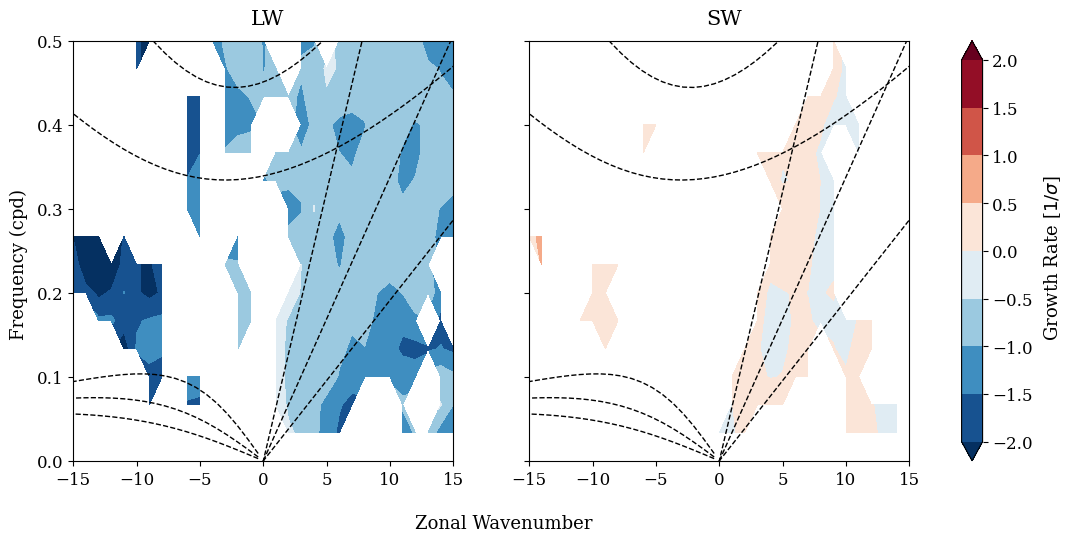

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(11, 6), sharey=True)

lw_diff_c = ax[0].contourf(
    wn, fr[fr > 0],
    np.fft.fftshift(sigma_masked["cntl"]["lw"])[fr > 0] - np.fft.fftshift(sigma_masked["ncrf"]["lw"])[fr > 0],
    levels=np.linspace(-2, 2, 9),
    cmap="RdBu_r",
    extend='both',
    norm = TwoSlopeNorm(vcenter=0)
)

for i in range(3):
    ax[0].plot(
        wn_ana[3, i, e_cond], fr_ana[3, i, e_cond],
        color = 'k', linewidth=1,
        linestyle="--"
    )
    ax[0].plot(
        wn_ana[4, i, :], fr_ana[4, i, :],
        color = 'k', linewidth=1,
        linestyle="--"
    )
    ax[0].plot(
        wn_ana[5, i, :], fr_ana[5, i, :],
        color = 'k', linewidth=1,
        linestyle="--"
    )
ax[0].set_xlim(-15, 15)
ax[0].set_ylim(0, 0.5)

sw_diff_c = ax[1].contourf(
    wn, fr[fr > 0],
    np.fft.fftshift(sigma_masked["cntl"]["sw"])[fr > 0] - np.fft.fftshift(sigma_masked["ncrf"]["sw"])[fr > 0],
    levels=np.linspace(-2, 2, 9),
    cmap="RdBu_r",
    extend='both',
    norm = TwoSlopeNorm(vcenter=0)
)
for i in range(3):
    ax[1].plot(
        wn_ana[3, i, e_cond], fr_ana[3, i, e_cond],
        color = 'k', linewidth=1,
        linestyle="--"
    )
    ax[1].plot(
        wn_ana[4, i, :], fr_ana[4, i, :],
        color = 'k', linewidth=1,
        linestyle="--"
    )
    ax[1].plot(
        wn_ana[5, i, :], fr_ana[5, i, :],
        color = 'k', linewidth=1,
        linestyle="--"
    )
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(0, 0.5)

plt.text(-37, 0.52, "LW", fontsize=15)
plt.text(-1, 0.52, "SW", fontsize=15)
plt.text(-24, -0.08, "Zonal Wavenumber", fontsize=13)
plt.text(-56, 0.15, "Frequency (cpd)", rotation=90, fontsize=13)
plt.text(25.5, 0.15, r"Growth Rate [$1/\sigma$]", rotation=90, fontsize=13)
plt.subplots_adjust(left=0.1, right=1.05, top=0.90, bottom=0.2)

plt.colorbar(sw_diff_c, ax=ax)
plt.savefig("growth_rate_diff.png", dpi=300)